In [1]:
import glob
import eigsep_observing.io as io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import os
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
import numpy as np
from hera_filters.dspec import dpss_operator, fit_solution_matrix
import h5py
import json
import healpy as hp
from healpy.sphtfunc import Alm
from scipy.special import sph_harm
from scipy.signal import get_window
import aipy

%matplotlib widget

In [2]:
mtn_tzone = ZoneInfo("America/Denver")
SQRT2 = np.sqrt(2)

def read_header(fname, keys=None):
    with h5py.File(fname, "r") as f:
        # header
        header_grp = f["header"]
        header = {k: v for k, v in header_grp.attrs.items() if keys is None or k in keys}
        for name, obj in header_grp.items():
            if keys is not None and name not in keys:
                continue
            if isinstance(obj, h5py.Group):
                header[name] = {k: v for k, v in obj.attrs.items()}
            else:
                header[name] = json.loads(obj[()])
    return header

def unix_time_to_local(unix_times):
    local_times = np.array([datetime.fromtimestamp(ts, tz=timezone.utc).astimezone(mtn_tzone) for ts in unix_times])
    return local_times

In [3]:
PATH = 'marjum-2025-07'
DATE_THRESH = 1735689600
if True:
    files = sorted(glob.glob(os.path.join(PATH, '*.h5')))
    print(files[0], files[-1])
    data, hdr, meta = io.read_hdf5(files[0])
    times = []
    acc_cnt = []
    for f in files:
        _hdr = read_header(f, {'times', 'acc_cnt'})
        times.append(_hdr['times'])
        acc_cnt.append(_hdr['acc_cnt'])
    
    times = np.concatenate(times)
    t_valid = np.where(times > DATE_THRESH)
    times = times[t_valid]
    local_times = unix_time_to_local(times)
    freqs = hdr['freqs']
    plt.figure()
    plt.plot(local_times)

IndexError: list index out of range

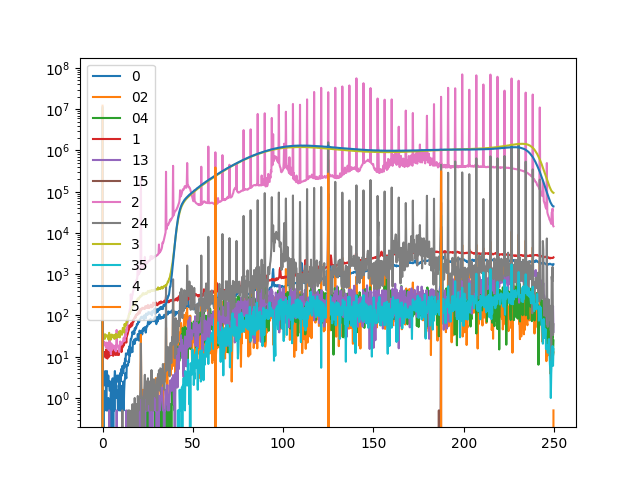

In [12]:
if True:
    plt.figure()
    for k, d in data.items():
        plt.semilogy(freqs, np.abs(d[0]), label=k)
    _ = plt.legend()

In [13]:
t_start = datetime(2025, 7, 20, 13, 11, 51, 774738, tzinfo=mtn_tzone)
t_stop =  datetime(2025, 7, 20, 14, 35, 41, 181442, tzinfo=mtn_tzone)

In [4]:
npz_file = 'marjum-2025-07_rotation.npz'
dtype_r = np.float32
dtype_c = np.complex64
if not os.path.exists(npz_file):
    data = {}
    times = []
    for f in files:
        print(f)
        hdr = read_header(f)
        if unix_time_to_local(hdr['times'][-1:]) < t_start:
            continue
        if unix_time_to_local(hdr['times'][:1]) > t_stop:
            continue
        dat, hdr, meta = io.read_hdf5(f)
        times.append(hdr['times'])
        for k in dat.keys():
            _d = dat[k]
            data[k] = data.get(k, []) + [_d]
    for k, v in data.items():
        data[k] = np.concatenate(v, dtype=dtype_r if len(k) == 1 else dtype_c)
    times = np.concatenate(times)
    local_times = unix_time_to_local(times)
    np.savez(npz_file, times=times, local_times=local_times, freqs=freqs, **data)
else:
    npz = np.load(npz_file, allow_pickle=True)
    data = {k: npz[k] for k in npz.files}
    times = data.pop('times')
    local_times = data.pop('local_times')
    freqs = data.pop('freqs')

/tmp/ipykernel_13422/3920149630.py:7: RuntimeWarning: divide by zero encountered in log10
  modeR = lambda x: np.log10(np.abs(x))


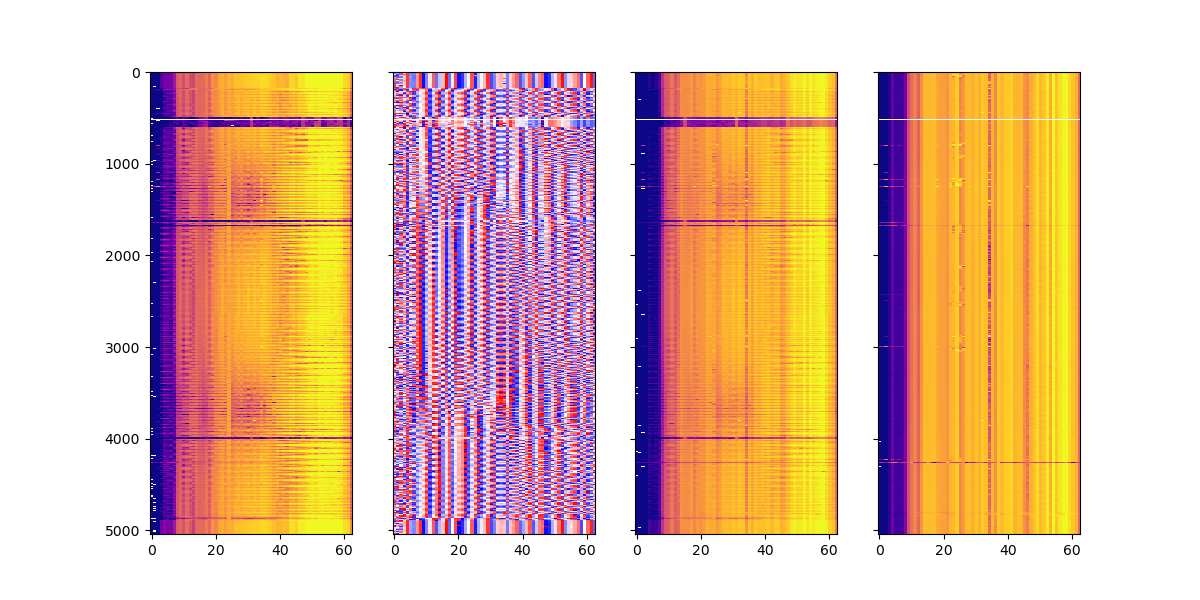

In [5]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 6), sharex=True, sharey=True)
k_1, k_2 = k12 = '24'
chs = np.arange(16, 1024, 16)
d_1 = data[k_1][:,chs] - 0.5 * (data[k_1][:,chs-1] + data[k_1][:,chs+1])
d_2 = data[k_2][:,chs] - 0.5 * (data[k_2][:,chs-1] + data[k_2][:,chs+1])
d12 = data[k12][:,chs] - 0.5 * (data[k12][:,chs-1] + data[k12][:,chs+1])
modeR = lambda x: np.log10(np.abs(x))
modeC = lambda x: np.angle(x)
kwargsR = dict(vmax=8, vmin=2, aspect='auto', interpolation='nearest', cmap='plasma')
kwargsC = dict(aspect='auto', interpolation='nearest', cmap='bwr')
_ = axes[0].imshow(modeR(d_1), **kwargsR)
_ = axes[1].imshow(modeC(d12), **kwargsC)
_ = axes[2].imshow(modeR(d12), **kwargsR)
_ = axes[3].imshow(modeR(d_2), **kwargsR)

In [6]:
def dpss_filter(y, amat, fmat):
    '''Apply the provided DPSS filter matrices to data.'''
    model = amat @ (fmat @ y)
    return model

#A_t = dpss_operator(times, filter_centers=[0 * 1e-3],
#                    filter_half_widths=[0.3 * 1e-3],
#                    eigenval_cutoff=[1e-12])[0]
##F_t = fit_solution_matrix(mask[:, 600-220], A_t)
#F_t = fit_solution_matrix(mask[:, 600], A_t)
##F_t_fm = fit_solution_matrix(mask[:, 396-220], A_t)
#F_t_fm = fit_solution_matrix(mask[:, 396], A_t)
#A_f = dpss_operator(freqs, filter_centers=[0],
#                    filter_half_widths=[150e-9],
#                    eigenval_cutoff=[1e-12])[0]
#F_f = fit_solution_matrix(fmask, A_f)
#dii_mdl[:, fm] = dpss_filter(dii[:, fm] * mask[:, fm], A_t, F_t_fm).real

/tmp/ipykernel_13422/3785082845.py:39: RuntimeWarning: divide by zero encountered in log10
  axes[0].imshow(np.log10(np.abs(data[k_1])), aspect='auto', interpolation='nearest', cmap='bwr')
/tmp/ipykernel_13422/3785082845.py:40: RuntimeWarning: divide by zero encountered in log10
  axes[1].imshow(np.log10(np.abs(d)), aspect='auto', interpolation='nearest', cmap='bwr')
/tmp/ipykernel_13422/3785082845.py:42: RuntimeWarning: divide by zero encountered in log10
  axes[3].imshow(np.log10(np.abs(data[k_2])), aspect='auto', interpolation='nearest', cmap='bwr')


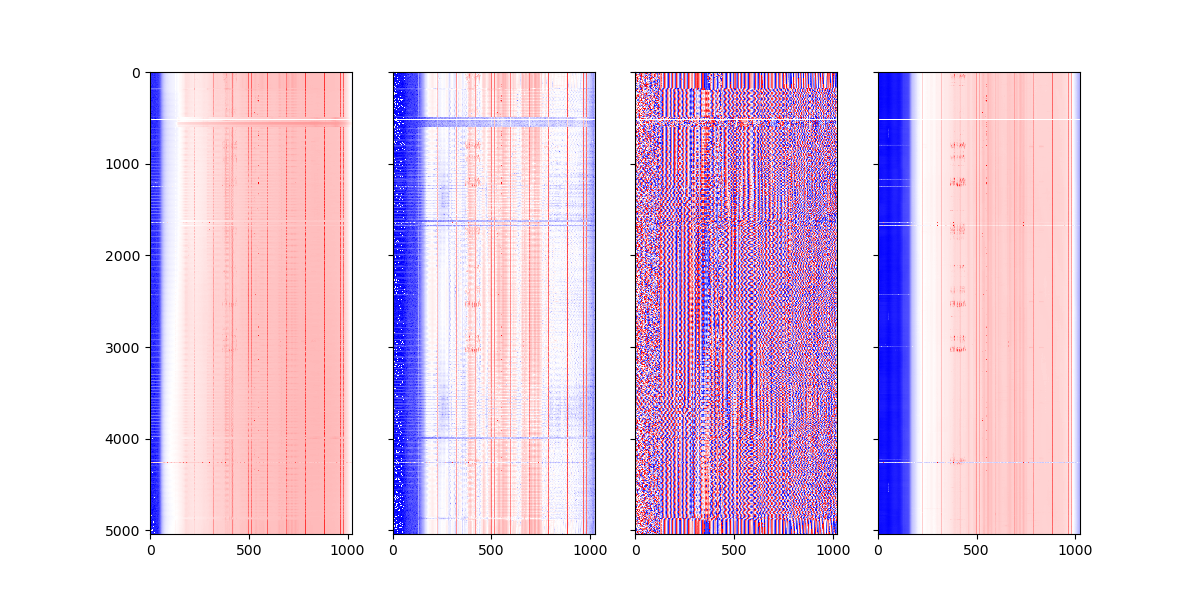

In [7]:
chs_tx = np.arange(0, freqs.size, 16)
chs_fm = np.where(np.logical_and(freqs >= 88, freqs < 110))[0]
chs_oob = np.where(freqs < 30)[0]
#chs_oob = np.where(freqs < 10)[0]

nsig_t = 3

d = data[k12].copy()
fmask = np.ones_like(freqs)
fmask[chs_tx] = 0
fmask[chs_fm] = 0
pwr_oob = np.mean(d[:, chs_oob] * fmask[None, chs_oob], axis=1)
pwr_oob -= np.median(pwr_oob)
pwr_mad = np.median(np.abs(pwr_oob))
#tmask = np.where(np.abs(pwr_oob) > nsig_t * pwr_mad, 0, 1)
tmask = np.ones_like(pwr_oob)
mask = tmask[:, None] * fmask[None, :]
mask = np.where(d > 10**6.7, 0, mask)
bad_chans = np.where(np.sum(1-mask, axis=0) > 10)[0]
fmask[bad_chans] = 0
mask[:, bad_chans] = 0
#A_t = dpss_operator(times, filter_centers=[0 * 1e-3],
#                    filter_half_widths=[0.3 * 1e-3],
#                    eigenval_cutoff=[1e-12])[0]
#F_t = fit_solution_matrix(tmask, A_t)
#window = get_window('blackmanharris', freqs.size)
#_d = np.fft.fft(window[None, :] * d * mask)

#plt.figure(figsize=(8, 8))
#plt.plot(np.sum(1-mask, axis=0))
#plt.plot(pwr_oob)
#plt.plot(pwr_oob * tmask)
#plt.imshow(np.log10(d[:, chs_oob] * fmask[None, chs_oob] * tmask[:, None]), aspect='auto', interpolation='nearest')
#plt.imshow(np.log10(d * mask), aspect='auto', interpolation='nearest', vmin=4, vmax=6.7)
#plt.imshow(np.log10((d - d_mdl) * mask), aspect='auto', interpolation='nearest', vmin=4, vmax=6.7)
#plt.imshow(np.log10((d_mdl) * mask), aspect='auto', interpolation='nearest', vmin=4, vmax=6.7)
#plt.imshow(np.log10(np.abs(np.diff(d))), aspect='auto', interpolation='nearest', cmap='plasma')
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(np.log10(np.abs(data[k_1])), aspect='auto', interpolation='nearest', cmap='bwr')
axes[1].imshow(np.log10(np.abs(d)), aspect='auto', interpolation='nearest', cmap='bwr')
axes[2].imshow(np.angle(d), aspect='auto', interpolation='nearest', cmap='bwr')
axes[3].imshow(np.log10(np.abs(data[k_2])), aspect='auto', interpolation='nearest', cmap='bwr')
#plt.imshow(np.log10(np.fft.fftshift(np.abs(np.fft.fft(window[None, :] * d * mask)))), aspect='auto', interpolation='nearest', vmax=8, vmin=5, cmap='plasma')
#plt.colorbar()
#plt.imshow(np.log10(d[:, chs_oob]), aspect='auto', interpolation='nearest')

6900524.1350000035


/tmp/ipykernel_13422/2505400985.py:16: RuntimeWarning: invalid value encountered in divide
  diff = r_2 - np.sum(r_2 * mask, axis=0) / np.sum(mask, axis=0)
/tmp/ipykernel_13422/3920149630.py:7: RuntimeWarning: divide by zero encountered in log10
  modeR = lambda x: np.log10(np.abs(x))


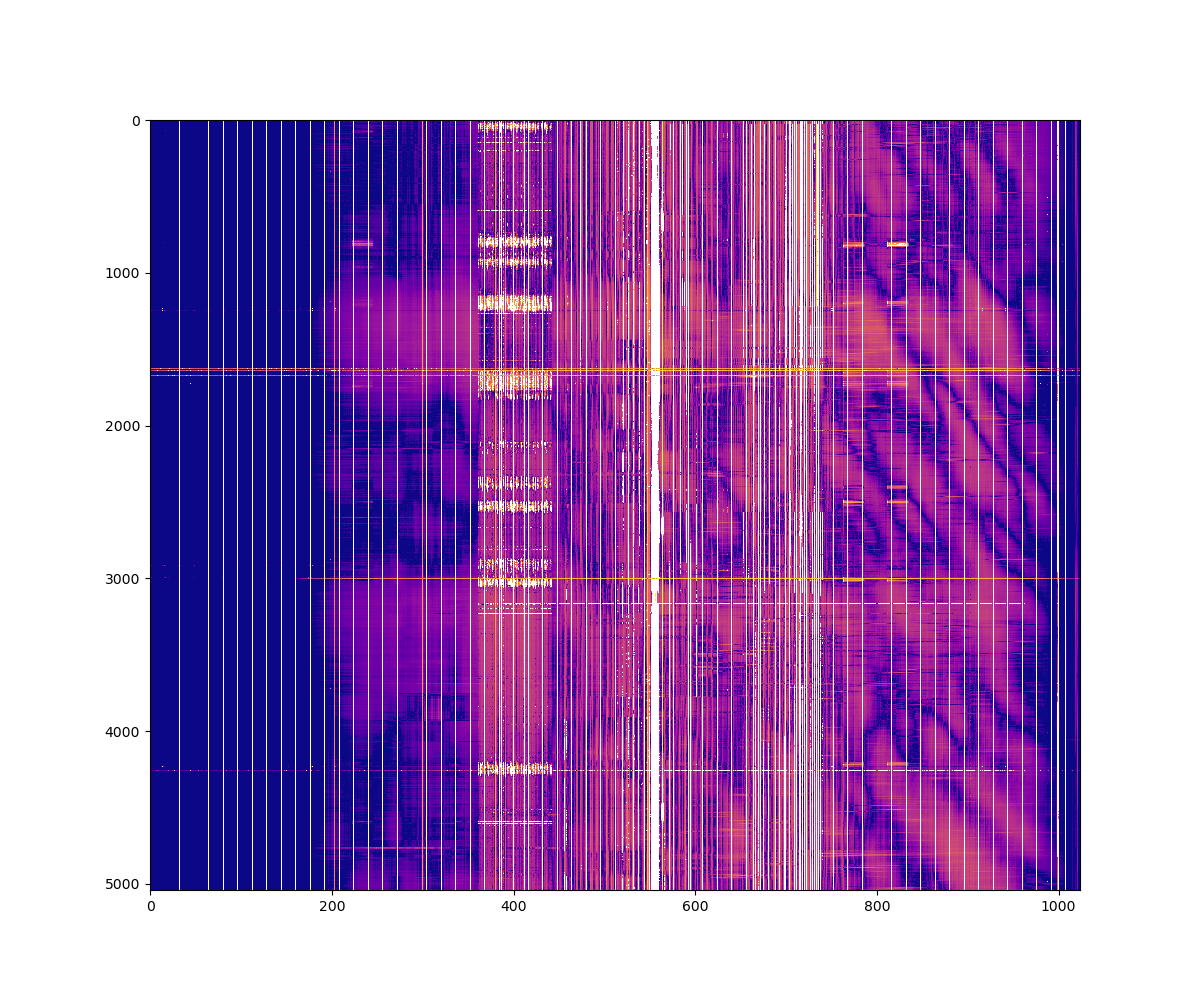

In [8]:
r_2 = data[k_2].copy()
mask = np.where(r_2 > 1e7, 0, 1)
mask[:,::16] = 0
tmask = np.where(np.median(r_2[:,:150], axis=1) > 1e3, 0, 1)[:, None]

diffa = r_2.copy()
diffa[1:-1,1:-1] -= 0.25 * (diffa[2:,2:] + diffa[2:,:-2] + diffa[:-2,2:] + diffa[:-2,:-2])
diffb = r_2.copy()
diffb[1:-1,1:-1] -= 0.25 * (diffa[1:-1,2:] + diffa[1:-1,:-2] + diffa[:-2,1:-1] + diffa[:-2,1:-1])
diff = np.where(diffa > diffb, diffb, diffa)
mask = np.where(diff > 1e6, 0, mask)

thresh = np.percentile(r_2 * mask, 99)
print(thresh)
mask = np.where(r_2 > thresh, 0, mask)
diff = r_2 - np.sum(r_2 * mask, axis=0) / np.sum(mask, axis=0)
thresh = np.percentile(diff, 95)
mask = np.where(diff > thresh, 0, mask)

#_d = data[k_1][:,340:540].copy()
#_d[:,1:-1] -= 0.5 * (_d[:,2:] + _d[:,:-2])
#_d[:,1:-1] -= np.sqrt(_d[:,2:] * _d[:,:-2])
#_d[:,0] = 0
#_d[:,-1] = 0
#_d /= 0.5 * (np.mean(_d[:4], axis=0) + np.mean(_d[-4:], axis=0))
#_d -= 1

#_d /= np.sqrt(np.median(np.abs(_d)**2, axis=0, keepdims=True))
plt.figure(figsize=(12,10))
#plt.imshow(modeR(d_1[1:-1] - 0.5 * (d_1[2:] + d_1[:-2])), **kwargsR)
#plt.imshow(modeR(data[k_1]), **kwargsR)
#plt.imshow(modeR(np.diff(r_2 * mask, axis=0)), aspect='auto', interpolation='nearest', vmax=7, vmin = 4, cmap='plasma')
plt.imshow(modeR(diff * mask), aspect='auto', interpolation='nearest', cmap='plasma', vmax=7, vmin=4)
#plt.plot(np.sum(r_2, axis=1))
#plt.imshow(modeC(data[k12][:, chs]), **kwargsC)
#plt.semilogy(data[k_1][-1])
#plt.semilogy(data[k_2][-1])
#plt.semilogy(np.abs(data[k12][-1]))

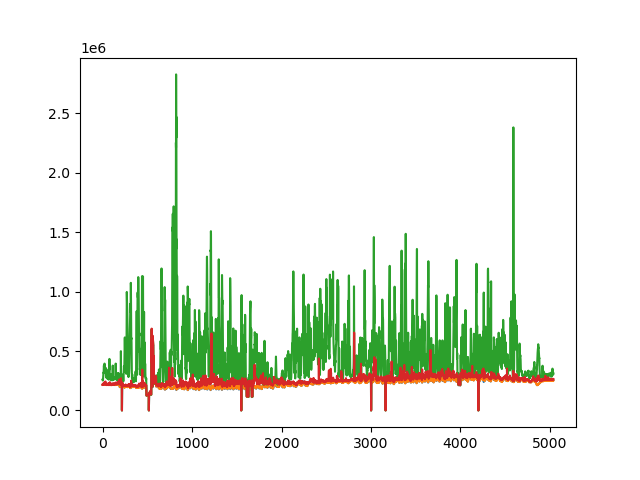

In [9]:
plt.figure()
plt.plot(data[k_1][:,358])
plt.plot(data[k_1][:,359])
plt.plot(data[k_1][:,361])
plt.plot(data[k_1][:,362])
#plt.plot(data[k_1][:,368])
#plt.plot(_d[:,165])

I suspect that ch=400 (transmitter index 24 below) has a discrepant beam response pattern
because the local transmitter is actually subdominant to an FM transmitter. Evidence
provided below shows that some FM bands (ch=412, particularly) show a similar modulation
with az/el that is in phase with ch=400, and when ch=412 is low, ch=400 returns to
following the transmitter profiles in ch=384 and ch=416.

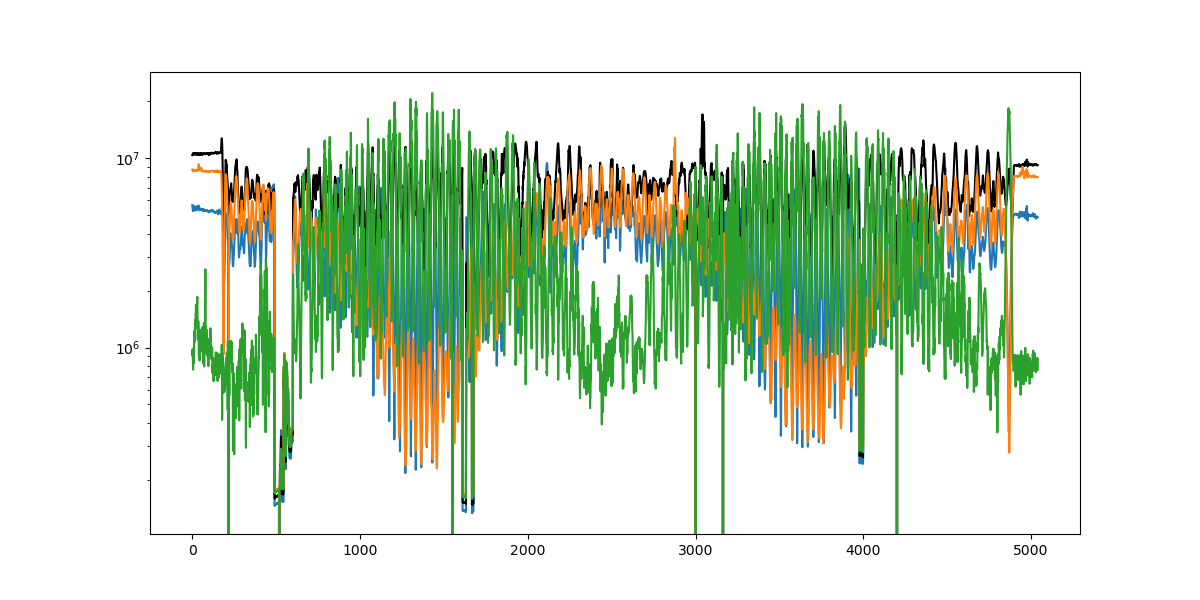

In [10]:
fig, axes = plt.subplots(nrows=1, sharex=True, figsize=(12,6))
axes = [axes]
_ = axes[0].semilogy(data[k_1][:, 384])
_ = axes[0].semilogy(data[k_1][:, 400], 'k')
_ = axes[0].semilogy(data[k_1][:, 416])
_ = axes[0].semilogy(data[k_1][:, 412])
#_ = axes[0].semilogy(data[k_1][:, 387])

On this particular run, we can check the phase of the cross-correlation before and after and verify that they are the same.
This implies that the platform and antenna were quite stable 

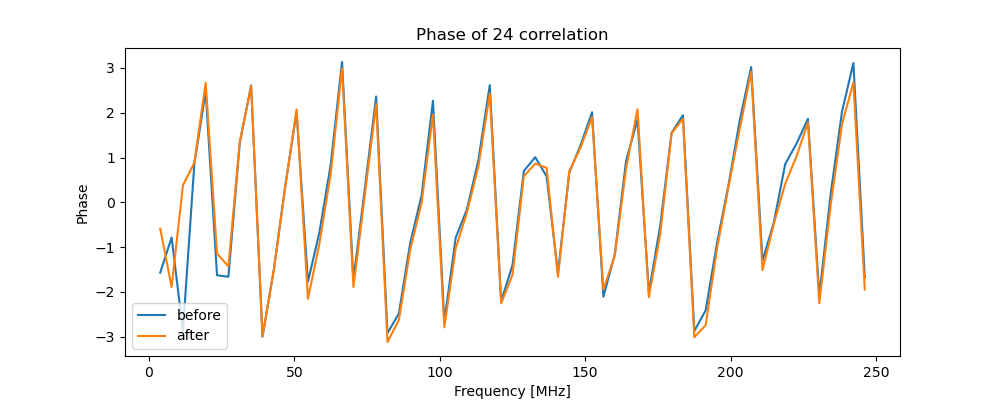

In [11]:
plt.figure(figsize=(10,4))
plt.title(f'Phase of {k12} correlation')
plt.plot(freqs[chs], np.angle(d12[ 0]), label='before')
plt.plot(freqs[chs], np.angle(d12[-1]), label='after')
plt.ylabel('Phase')
plt.xlabel('Frequency [MHz]')
_ = plt.legend()

In [12]:
AZ_STEPS = 72  # with endpoint=True
period = 68.78
#t_start = 1753038750 # s utc
t_start = 1753038750 + period/2 # s utc
t_cut = [(1753039060, 1753039181), (1753042808, 1753042834), (1753043111, 1753043119)]  # junk data
i_start = np.searchsorted(times, t_start)
norm = 1 / np.mean(d_1[:i_start], axis=0, keepdims=True)
norm[:,:4] = 0
t_stop = t_start + AZ_STEPS * period
i_stop = np.searchsorted(times, t_stop)

valid = np.ones(times.shape, dtype=bool)
valid = np.where(d_1[:,52] * norm[:,52] < 1e-4, False, ~np.isnan(d_1[:,52]))
for ti, tj in t_cut:
    i, j = np.searchsorted(times, ti), np.searchsorted(times, tj)
    valid[i:j] = False
    
valid[1:-1] = np.logical_and(valid[1:-1], np.logical_and(valid[:-2], valid[2:]))

if False:
    fig, axes = plt.subplots(nrows=2, sharex=True)
    #_ = plt.semilogy(local_times[sl], data[ANT][:,23][sl])
    _ = axes[0].semilogy(times, d_1[:,52:60] * norm[:,52:60] * valid[:,None])
    _ = axes[0].vlines([t_start, t_stop], ymax=1e0, ymin=1e-4, color='k')
    _ = axes[1].plot(times, np.angle(d12[:,52]))
    _ = axes[1].vlines([t_start, t_stop], ymax=np.pi, ymin=-np.pi, color='k')
    #_ = axes[1].plot(times-68.78, np.angle(d12[:,33]))

In [13]:
class BeamFit:
    def __init__(self, times, az_steps=AZ_STEPS, lmax=5):
        self.az_steps = az_steps
        self.times = times
        self.lmax = lmax
        self._el_ax = self._ant_pvec = np.array([1, 0, 0], dtype=dtype_r)
        self._az_ax = np.array([0, 0, 1], dtype=dtype_r)
        self.prms = {}
        self.ant_pvec = self.polresp = self.A_Ylm = self.A = None

    def _set_timing_params(self, prms):
        keys = {'t_off', 'el_off', 't_az_step', 'period'}
        for k in keys:
            if k in prms and prms[k] != self.prms.get(k, None):
                self.prms[k] = prms[k]
                self.az_deg = self.el_deg = self.ant_pvec = self.A_Ylm = self.A = None

    def _set_pol_params(self, prms):
        keys = {'prz', 'px', 'py'}
        for k in keys:
            if k in prms and prms[k] != self.prms.get(k, None):
                self.prms[k] = prms[k]
                self.gnd_pvecs = self.polresp = self.A = None

    def set_params(self, prms):
        self._set_timing_params(prms)
        self._set_pol_params(prms)
        
    def build_az_el(self):
        '''Build az/el coordinates.'''
        if self.ant_pvec is not None:
            return
        az, el, inds = [], [], []
        t_off, el_off, t_az_step, period = self.prms['t_off'], self.prms['el_off'], self.prms['t_az_step'], self.prms['period']
        i = 0
        t_i = self.times[0] + t_off
        for cnt, _az in enumerate(np.linspace(-180, 180, self.az_steps, endpoint=True)):
            t_f = t_i + period
            while i < self.times.size and self.times[i] < t_f - t_az_step:
                az.append(_az)
                if cnt % 2 == 0:
                    el.append(-180 + 360 * (self.times[i] - t_i) / (period - t_az_step))
                else:
                    el.append( 180 - 360 * (self.times[i] - t_i) / (period - t_az_step))
                inds.append(i)
                i += 1
            while i < self.times.size and self.times[i] < t_f:
                az.append(_az + (360 / (self.az_steps - 1)) * (self.times[i] - (t_f - t_az_step))/t_az_step)
                el.append(el[-1])
                inds.append(i)
                i += 1
            t_i = t_f
        self.az_deg = np.array(az)
        self.el_deg = np.array(el) + el_off
        self.inds = np.array(inds)
        rot_az = aipy.coord.rot_m(np.deg2rad(self.az_deg), self._az_ax)
        rot_el = aipy.coord.rot_m(np.deg2rad(self.el_deg), self._el_ax)
        self.ant_pvec = np.einsum('pab,pbc,c->pa', rot_el, rot_az, self._ant_pvec)

    def build_pol_resp(self):
        self.build_az_el()
        if self.polresp is not None:
            return
        pvec = np.array([[self.prms['px'], 0, 0], [0, self.prms['py'], 0]], dtype=dtype_r)
        rot_m = aipy.coord.rot_m(np.deg2rad(self.prms['prz']), np.array([0, 0, 1])).astype(dtype_r)
        self.gnd_pvecs = np.dot(rot_m, pvec.T).T
        if self.gnd_pvecs.ndim == 1:
            self.gnd_pvecs = self.gnd_pvecs[None, :]
        resp = np.dot(self.ant_pvec, self.gnd_pvecs.T)
        self.polresp = np.sum(np.abs(resp)**2, axis=-1)

    def build_A_Ylm(self):
        self.build_az_el()
        if self.A_Ylm is not None:
            return
        phi = np.deg2rad(self.az_deg)
        theta = np.deg2rad(self.el_deg)
        theta = np.mod(theta, 2*np.pi)
        theta = np.where(theta > np.pi, 2*np.pi - theta, theta)
        phi = np.mod(phi, 2*np.pi)
    
        N = theta.size
        P = (self.lmax + 1)**2
        A = np.empty((N, P), dtype=dtype_r)
    
        # Keep track of which column corresponds to which (l,m,kind)
        # kind ∈ {'m0','c','s'} for m=0, cos-like, sin-like
        self._meta = []
        col = 0
        for ell in range(self.lmax + 1):
            # m = 0 term (purely real)
            Y_l0 = sph_harm(0, ell, phi, theta).real
            #Y_l0 *= gen_pol_resp(az_deg, el_deg, gnd_pvecs)
            A[:, col] = Y_l0
            self._meta.append((ell, 0, 'm0'))
            col += 1
    
            # m > 0 terms: sqrt(2)*Re and sqrt(2)*Im
            for m in range(1, ell + 1):
                Y_lm = sph_harm(m, ell, phi, theta)  # complex
                #Y_lm *= gen_pol_resp(az_deg, el_deg, gnd_pvecs)
                A[:, col] = SQRT2 * Y_lm.real
                A[:, col+1] = SQRT2 * Y_lm.imag
                self._meta.append((ell, m, 'c'))
                self._meta.append((ell, m, 's'))
                col += 2
    
        assert col == P
        self.A_Ylm = A

    def build_A(self):
        self.build_pol_resp()
        self.build_A_Ylm()
        if self.A is not None:
            return
        self.A = self.A_Ylm * self.polresp[:, None]

    def _realcoeff_to_alm(self, coeff):
        """
        Convert real-basis coeffficients (matching design-matrix columns) into a
        healpy alm array (complex, m>=0). For a real sky, alms obey:
          a_{l,-m} = (-1)^m a_{l m}^*
        We only fill m>=0 as healpy expects.
        """
        alm = np.zeros(Alm.getsize(self.lmax), dtype=dtype_c)
        for k, (ell, m, kind) in enumerate(self._meta):
            if m == 0 and kind == 'm0':
                alm[Alm.getidx(self.lmax, ell, 0)] = coeff[k]
            elif kind in ('c'):
                c = coeff[k]
                s = coeff[k + 1]
                a_lm = (c - 1j * s) / SQRT2
                alm[Alm.getidx(self.lmax, ell, m)] = a_lm
        return alm

    def fit_alms(self, ymeas, w=None, reg=None, rcond=1e-10):
        self.build_A()
    
        # Apply weights (as sqrt weights on rows)
        ymeas = ymeas[self.inds]
        if w is None:
            w = np.ones_like(ymeas)
        else:
            w = w[self.inds]
        sqrtw = np.sqrt(w)
        Aw = self.A * sqrtw[:, None]
        yw = ymeas * sqrtw
    
        # Optional ridge regularization: stack sqrt(reg)*I
        if reg is not None and reg > 0:
            P = self.A.shape[1]
            Aw = np.vstack([Aw, np.sqrt(reg) * np.eye(P)])
            yw = np.concatenate([yw, np.zeros(P)])
    
        coeff = np.linalg.lstsq(Aw[self.inds], yw[self.inds], rcond=rcond)[0]
        yhat = self.A @ coeff
        chisq = np.sum(w * (ymeas[self.inds] - yhat[self.inds])**2)
        alm = self._realcoeff_to_alm(coeff)
        return alm, chisq, yhat

In [14]:
# slice data/times
sl = slice(i_start, i_stop)
_times = times[sl].copy()
_times -= _times[0]
# optional for strictly data-driven double-period folding
#_times_rnd = np.floor(_times / (2 * period))
#_times_mod = _times - _times_rnd * (2 * period)
val = valid[sl]

print(local_times[sl][0], local_times[sl][-1])

2025-07-20 13:13:04.789182-06:00 2025-07-20 14:35:35.812733-06:00


In [15]:
saved_sols = {
     5: ( 45.40,   0.16), # chisq=   1171.9
     6: (-36.60,   1.00), # chisq=    213.8
     7: ( 15.00,   0.36), # chisq=     94.5
     8: (  7.40,   0.49), # chisq=      9.2
     9: ( 21.40,   0.36), # chisq=      6.2
    10: (-36.60,   1.00), # chisq=    300.3
    11: ( 38.20,   0.16), # chisq=     55.0
    12: (-20.60,   1.00), # chisq=    176.6
    13: (  8.20,   1.00), # chisq=    388.1
    14: (  3.80,   0.81), # chisq=     86.0
    15: (-33.00,   0.64), # chisq=     33.0
    16: ( -6.60,   0.49), # chisq=     22.9
    17: (  3.00,   0.36), # chisq=      8.8
    18: (-28.20,   0.81), # chisq=    165.1
    19: ( 32.20,   0.36), # chisq=     31.7
    20: ( 13.00,   0.64), # chisq=     84.0
    21: (-35.00,   0.49), # chisq=     20.6
    22: ( -8.60,   0.49), # chisq=     17.9
    23: ( 39.00,   0.64), # chisq=     57.8
    24: (-25.80,   0.49), # chisq=     60.4
    25: ( -7.80,   0.16), # chisq=      8.7
    26: ( -1.40,   0.16), # chisq=     14.8
    27: (-12.60,   0.16), # chisq=     23.2
    28: (  5.40,   0.36), # chisq=     15.9
    29: (-14.20,   0.16), # chisq=      8.5
    30: (-14.60,   0.04), # chisq=     13.5
    31: ( -7.40,   0.16), # chisq=     13.2
    32: (-11.40,   0.16), # chisq=     11.3
    33: ( -9.80,   0.16), # chisq=     12.9
    34: ( -3.40,   0.25), # chisq=     25.5
    35: ( -7.80,   0.16), # chisq=      6.1
    36: (-21.40,   0.36), # chisq=     15.9
    37: (-10.20,   0.49), # chisq=     25.0
    38: ( 36.20,   0.64), # chisq=     44.8
    39: ( -3.80,   0.81), # chisq=    283.2
    40: ( -8.20,   0.81), # chisq=    162.2
    41: (-19.00,   1.00), # chisq=    283.8
    42: (-23.40,   1.00), # chisq=    247.1
    43: (-26.20,   1.00), # chisq=    100.7
    44: (-28.60,   1.00), # chisq=     73.9
    45: (-31.40,   1.00), # chisq=     58.6
    46: (-36.60,   1.00), # chisq=     34.2
    47: (-35.40,   1.00), # chisq=     64.6
    48: (-36.60,   1.00), # chisq=     59.7
    49: (-40.60,   1.00), # chisq=    106.3
    50: (-42.60,   1.00), # chisq=     59.3
    51: (-43.80,   1.00), # chisq=     48.9
    52: (-37.40,   1.00), # chisq=    170.8
    53: (-40.60,   1.00), # chisq=    107.1
    54: (-37.80,   1.00), # chisq=    234.9
    55: (-36.60,   1.00), # chisq=    199.3
    56: (-37.80,   1.00), # chisq=    248.2
    57: (-39.80,   1.00), # chisq=    494.7
    58: ( 47.00,   0.16), # chisq=    219.0
    59: ( 47.00,   0.16), # chisq=    189.6159
    60: ( 34.20,   0.16), # chisq=    305.4
    61: ( 47.00,   0.16), # chisq=    159.6
    62: ( 35.80,   0.16), # chisq=     78.6
}

In [16]:
t_az_step = 1.0
prms = dict(
    t_az_step = t_az_step, # XXX degenerate with beam width, need empirical measurement
    t_off = -2.4 + t_az_step/2,
    el_off = -5.0,  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
    # az_off is unnecessary given fitting of polarization angle
    prz = 0.0,
    px = 1.0,
    py = 0.0,
    period = period,
)
fitter = BeamFit(_times[val])
fitter.set_params(prms)

In [17]:
#for ch in range( 5, 63):
for ch in range( 5, 10):
    ymeas = d_1[:,ch][sl][val] * norm[:,ch]

    try:
        rz0, pfrac0 = saved_sols[ch]
        prms['prz'] = rz0
        prms['px'] = np.sqrt(1-pfrac0**2)
        prms['py'] = pfrac0**2
        fitter.set_params(prms)
        alm_fit, chisq_best, yhat = fitter.fit_alms(ymeas)
        diff2 = np.abs(yhat - ymeas[fitter.inds])**2
        for cnt in range(2):
            diff2 = np.abs(yhat - ymeas[fitter.inds])**2
            if cnt == 0:
                std2 = np.median(diff2)
            else:
                std2 = np.sum(diff2 * w) / np.sum(w)
            w = np.where(diff2 > 4**2 * std2, 0, 1)
            alm_fit, chisq_best, yhat = fitter.fit_alms(ymeas, w=w)
            r_best = (prms.copy(), alm_fit, yhat)
        ##for rz in np.linspace(-45, 45, 46):
        for rz in rz0 + np.linspace(-2, 2, 11):
            prms['prz'] = rz
            for pfrac in pfrac0 + np.linspace(-0.2, 0.2, 5): 
            #for pfrac in np.linspace(0, 1, 6):
                if pfrac < 0 or pfrac > 1:
                    continue
                prms['px'] = np.sqrt(1 - pfrac**2)
                prms['py'] = pfrac**2
                fitter.set_params(prms)
                alm_fit, chisq, yhat = fitter.fit_alms(ymeas, w=w)
                if chisq < chisq_best:
                    chisq_best = chisq
                    r_best = (prms.copy(), alm_fit, yhat)
    except(KeyError):
        chisq_best = np.inf
        for rz in np.linspace(0, 90, 46):
            for pfrac in np.linspace(0, 1, 6):
                prms['prz'] = rz
                prms['px'] = np.sqrt(1-pfrac**2)
                prms['py'] = pfrac**2
                fitter.set_params(prms)
                alm_fit, chisq, yhat = fitter.fit_alms(ymeas)
                if chisq < chisq_best:
                    chisq_best = chisq
                    r_best = (prms.copy(), alm_fit, yhat)
    print(f"    {ch:2}: ({r_best[0]['prz']:6.2f}, {r_best[0]['py']:6.2f}), # chisq={chisq_best:9.1f}")
    if True:
        prms, alm_fit, yhat = r_best
        fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
        s = 15
        _ = axes[0].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(ymeas[fitter.inds] * w), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
        _ = axes[1].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=(ymeas[fitter.inds]-yhat), s=s, cmap='bwr', vmax=2, vmin=-2)
        _ = axes[2].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(yhat), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
        axes[0].set_ylabel('Azimuth [deg]')
        for ax in axes:
            ax.set_xticks(np.linspace(-180, 180, 9))
            ax.set_yticks(np.linspace(-180, 180, 9))
            ax.grid()
            ax.set_xlabel('Elevation [deg]')
        _ = axes[0].set_title(f'{ch}: Measured')
        _ = axes[1].set_title(f'{ch}: Diff')
        _ = axes[2].set_title(f'{ch}: Model')
        _ = plt.tight_layout()
        plt.savefig(f'beam_plot_ch{ch:02d}.png')
        plt.close()

/tmp/ipykernel_13422/550074290.py:92: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_l0 = sph_harm(0, ell, phi, theta).real
/tmp/ipykernel_13422/550074290.py:100: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_lm = sph_harm(m, ell, phi, theta)  # complex


     5: ( 45.40,   0.13), # chisq=   1177.3


/tmp/ipykernel_13422/4180753178.py:53: RuntimeWarning: divide by zero encountered in log10
  _ = axes[0].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(ymeas[fitter.inds] * w), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
/tmp/ipykernel_13422/4180753178.py:53: RuntimeWarning: invalid value encountered in log10
  _ = axes[0].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(ymeas[fitter.inds] * w), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
/tmp/ipykernel_13422/4180753178.py:55: RuntimeWarning: invalid value encountered in log10
  _ = axes[2].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(yhat), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)


     6: (-36.20,   1.00), # chisq=    215.7
     7: ( 13.80,   0.31), # chisq=     90.9
     8: (  7.40,   0.48), # chisq=      9.3
     9: ( 21.40,   0.31), # chisq=      7.7


In [30]:
#if True:
for ch in range(79, 1024):
    outfile = f"map_ch{ch:04d}.png"
    if os.path.exists(outfile):
        continue
    print(ch)
    #t_az_step = 1.0 # XXX degenerate with beam width, need empirical measurement
    #t_off = -2.4 + t_az_step/2
    #el_off = -5.0  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
    # az_off is unnecessary given fitting of polarization angle

    #az, el, inds = build_az_el(_times, t_off, el_off, t_az_step, period)

    ymeas = data[k_1][:,ch][sl][val] / data[k_1][0, ch] #* mask[sl][val][:,ch]
    alm_fit, chisq_best, yhat = fitter.fit_alms(ymeas)
    fig = plt.figure(figsize=(6,6))
    axes = plt.gca()
    #fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
    axes = [axes]
    _ = axes[0].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(ymeas[fitter.inds]), s=15, cmap='plasma', vmax=0.5, vmin=-1.0)
    #_ = axes[1].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=(ymeas[fitter.inds]-yhat), s=s, cmap='bwr', vmax=2, vmin=-2)
    #_ = axes[0].scatter(el[val[inds]], az[val[inds]], c=np.log10(d_1[:,ch][sl][inds][val[inds]] * norm[:,ch]), s=25, cmap='plasma', vmax=0.5, vmin=-1.5)
    #_ = axes[0].scatter(el[val[inds]], az[val[inds]], c=-np.cos(np.deg2rad(el[val[inds]])), s=25, cmap='tab10', vmax=1, vmin=-1)
    #_ = axes[1].scatter(el[val[inds]], az[val[inds]], c=np.log10(data[k_1][:,ch*16+3][sl][inds][val[inds]] * norm[:,ch]), s=25, cmap='plasma')#, vmax=-1.5, vmin=-2)
    #_ = axes[1].scatter(el[val[inds]], az[val[inds]], c=np.angle(d12[:,ch][sl][inds][val[inds]] * norm[:,ch]), s=25, cmap='tab10', vmax=np.pi, vmin=-np.pi)#, vmax=-1.5, vmin=-2)
    #plt.colorbar()
    axes[0].set_xticks(np.linspace(-180, 180, 9))
    axes[0].set_yticks(np.linspace(-180, 180, 9))
    #axes[1].set_xticks(np.linspace(-180, 180, 9))
    #axes[1].set_yticks(np.linspace(-180, 180, 9))
    _ = axes[0].grid()
    plt.title(f"{freqs[ch]:6.2f} MHz")
    plt.savefig(outfile)
    plt.close()
    #_ = axes[1].grid()

79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
3

/tmp/ipykernel_145067/3511890382.py:20: RuntimeWarning: invalid value encountered in log10
  _ = axes[0].scatter(fitter.el_deg[fitter.inds], fitter.az_deg[fitter.inds], c=np.log10(ymeas[fitter.inds]), s=15, cmap='plasma', vmax=0.5, vmin=-1.0)


548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797


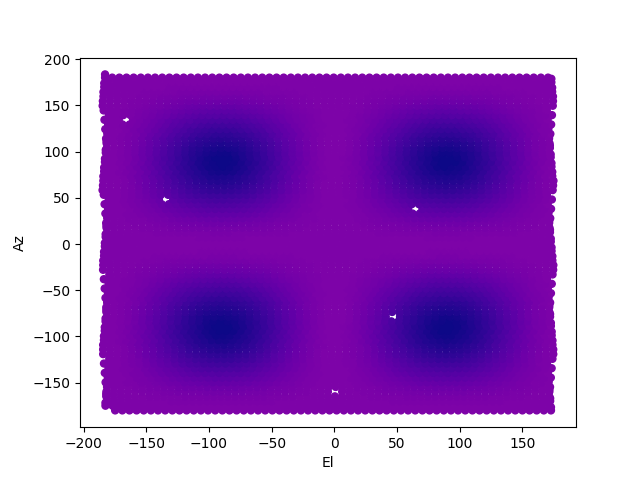

In [17]:
if True:
    rz = 90
    pfrac = 0.5
    gnd_pol_vecs = gen_pol_vecs(rz, pfrac, 1-pfrac)
    
    plt.figure()
    #_ = plt.scatter(el, az, c=gen_pol_resp(az, el, gnd_pol_vec), s=25, cmap='plasma', vmax=0.5, vmin=-1.5)
    _ = plt.scatter(el, az, c=gen_pol_resp(az, el, gnd_pol_vecs), s=25, cmap='plasma', vmax=1, vmin=0)
    _ = plt.xlabel('El')
    _ = plt.ylabel('Az')

In [22]:
t_az_step = 1.0 # XXX degenerate with beam width, need empirical measurement
t_off = -2.4 + t_az_step/2
el_off = -5.0  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
# az_off is unnecessary given fitting of polarization angle
az, el, inds = build_az_el(_times, t_off, el_off, t_az_step, period)

for ch in range( 5, 63):
    ymeas = d_1[:,ch][sl][inds][val[inds]] * norm[:,ch]

    try:
        rz0, pfrac0 = saved_sols[ch]
        gnd_pol_vecs = gen_pol_vecs(rz0, 1-pfrac0, pfrac0)
        alm_fit, chisq_best, yhat = fit_alm_from_points(az[val[inds]], el[val[inds]], ymeas, lmax=5, gnd_pvecs=gnd_pol_vecs)
        r_best = (rz, pfrac, alm_fit, yhat)
        for rz in rz0 + np.linspace(-2, 2, 11):
            for pfrac in pfrac0 + np.linspace(-0.2, 0.2, 5): 
                gnd_pol_vecs = gen_pol_vecs(rz, 1-pfrac, pfrac)
                alm_fit, chisq, yhat = fit_alm_from_points(az[val[inds]], el[val[inds]], ymeas, lmax=5, gnd_pvecs=gnd_pol_vecs)
                if chisq < chisq_best:
                    chisq_best = chisq
                    r_best = (rz, pfrac, alm_fit, yhat)
    except(KeyError):
        chisq_best = np.inf
        for rz in np.linspace(0, 90, 46):
            for pfrac in np.linspace(0, 1, 6):
                gnd_pol_vecs = gen_pol_vecs(rz, 1-pfrac, pfrac)
                #gnd_pol_vecs = np.dot(aipy.coord.rot_m(np.deg2rad(rz), np.array([0, 0, 1])),
                #                np.array([[1-pfrac,     0, 0],
                #                          [      0, pfrac, 0]]).T).T
                alm_fit, chisq, yhat = fit_alm_from_points(az[val[inds]], el[val[inds]], ymeas, lmax=5, gnd_pvecs=gnd_pol_vecs)
                if chisq < chisq_best:
                    chisq_best = chisq
                    r_best = (rz, pfrac, alm_fit, yhat)
    print(ch, r_best[0], r_best[1], chisq_best)

    if True:
        rz, pfrac, alm_fit, yhat = r_best
        fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
        s = 15
        _ = axes[0].scatter(el[val[inds]], az[val[inds]], c=np.log10(ymeas), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
        _ = axes[1].scatter(el[val[inds]], az[val[inds]], c=ymeas-yhat, s=s, cmap='bwr', vmax=2, vmin=-2)
        _ = axes[2].scatter(el[val[inds]], az[val[inds]], c=np.log10(yhat), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
        axes[0].set_ylabel('Azimuth [deg]')
        for ax in axes:
            ax.set_xticks(np.linspace(-180, 180, 9))
            ax.set_yticks(np.linspace(-180, 180, 9))
            ax.grid()
            ax.set_xlabel('Elevation [deg]')
        _ = axes[0].set_title(f'{ch}: Measured')
        _ = axes[1].set_title(f'{ch}: Abs Diff')
        _ = axes[2].set_title(f'{ch}: Model')
        _ = plt.tight_layout()
        plt.savefig(f'beam_plot_ch{ch:2d}.png')
        plt.close()

/tmp/ipykernel_19534/2313409119.py:23: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_l0 = sph_harm(0, ell, phi, theta).real
/tmp/ipykernel_19534/2313409119.py:31: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_lm = sph_harm(m, ell, phi, theta)  # complex


5 54.4 0.0 2880.779296875


/tmp/ipykernel_19534/404005063.py:40: RuntimeWarning: invalid value encountered in log10
  _ = axes[0].scatter(el[val[inds]], az[val[inds]], c=np.log10(ymeas), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
/tmp/ipykernel_19534/404005063.py:42: RuntimeWarning: invalid value encountered in log10
  _ = axes[2].scatter(el[val[inds]], az[val[inds]], c=np.log10(yhat), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)


6 52.8 0.2 736.6181030273438


/tmp/ipykernel_19534/404005063.py:40: RuntimeWarning: divide by zero encountered in log10
  _ = axes[0].scatter(el[val[inds]], az[val[inds]], c=np.log10(ymeas), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)


7 20.4 0.30000000000000004 271.2376708984375
8 8.8 0.4 11.323997497558594
9 21.6 0.30000000000000004 7.046624183654785
10 53.6 -0.2 476.8153076171875
11 38.4 0.2 55.75120162963867
12 69.6 0.2 524.7568359375
13 7.6 0.8 215.90301513671875
14 3.2 0.6 59.74182891845703
15 50.0 0.5 39.1881103515625
16 82.4 0.6 28.169315338134766
17 2.8000000000000003 0.30000000000000004 12.436125755310059
18 73.6 -0.1 166456.5625
19 32.4 0.30000000000000004 32.465999603271484
20 14.4 0.6 92.53562927246094
21 54.0 0.5 22.409683227539062
22 80.8 0.6 285.10284423828125
23 40.4 0.5 102.21700286865234
24 61.6 0.6 184.75735473632812
25 61.6 0.6 18.282272338867188
26 -0.7999999999999998 0.2 19.805906295776367
27 77.2 0.8 23.649009704589844
28 5.2 0.30000000000000004 23.912519454956055
29 76.0 1.2 11.191812515258789
30 74.4 1.0 42.40670394897461
31 82.8 1.2 14.455589294433594
32 78.4 0.9 65.63817596435547
33 78.4 0.9 15.27847671508789
34 0.40000000000000036 0.30000000000000004 4837.8798828125
35 0.40000000000000036

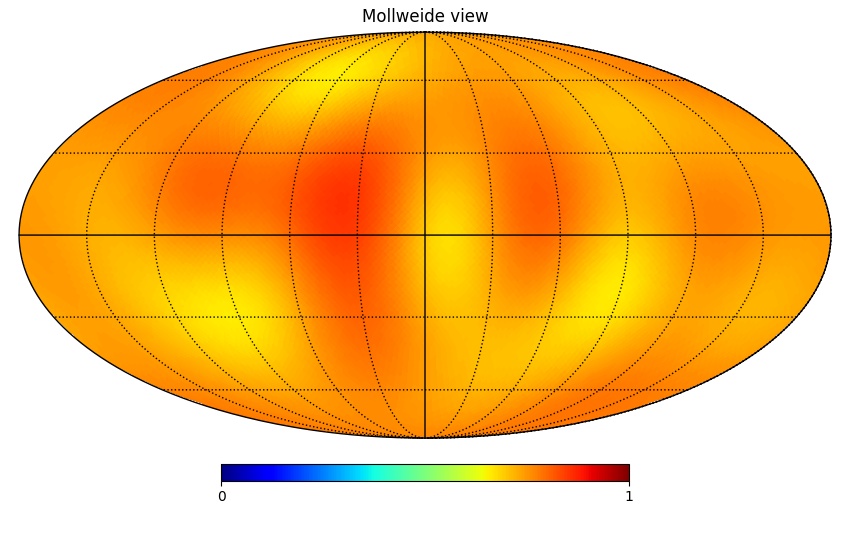

In [41]:
hmap = hp.alm2map(alm_fit.astype(complex), nside=32, lmax=5)
#vmin, vmax = -0.7, 0.7
vmin, vmax = 0, 1
hp.mollview(np.log10(hmap), max=vmax, min=vmin, cmap='jet')
hp.graticule()

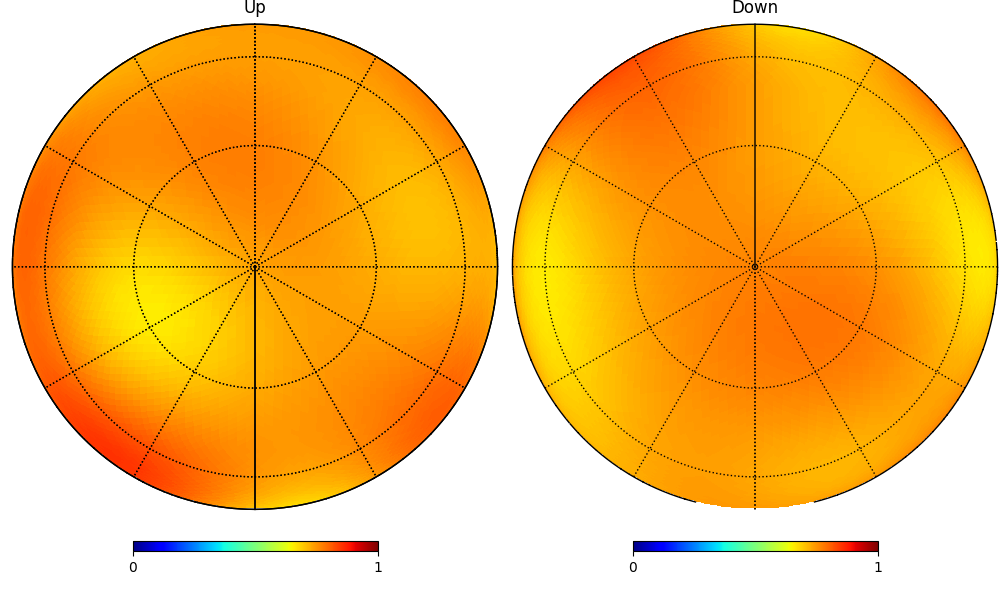

In [42]:
plt.figure(figsize=(10, 6))

hp.orthview(
    np.log10(hmap), rot=(0, 90, 0), half_sky=True, sub=(1, 2, 1),
    min=vmin, max=vmax, title="Up", xsize=800, cmap='jet'
)
hp.graticule()

# South pole: look from (-90° lat)
hp.orthview(
    np.log10(hmap), rot=(0, -90, 0), half_sky=True, sub=(1, 2, 2),
    min=vmin, max=vmax, title="Down", xsize=800, cmap='jet'
)
hp.graticule()